In [1]:
import pandas as pd
import numpy as np

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight', dpi=300)
    pdf.close()
    return

In [3]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_file = "/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/lifestyle/train_cohort.csv"
lifestyle_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/lifestyle_factors/data/lifestyle_processed/filtered_lifestyle_binarized.csv.gz"

In [4]:
genotype_df = pd.read_csv(genotype_file)
phenotype_df = pd.read_csv(phenotype_file)
combo_df = pd.read_csv(combo_file)

In [5]:
phenotype_df["sample_names"] = phenotype_df.sample_names.astype(str)

In [6]:
lifestyle_df = pd.read_csv(lifestyle_file)

In [7]:
all_items = "|".join(combo_df.uniq_items.values).split("|")

In [8]:
all_lifestyles = set(lifestyle_df.columns)
all_lifestyles.remove("Sample_Name")

In [9]:
all_genes = set([i.replace("Input_", "", 1) for i in all_items if i.replace("Input_", "", 1) not in all_lifestyles])

In [10]:
all_gene_samples = set(",".join(genotype_df.loc[genotype_df.gene.isin(all_genes)].samples.values).split(","))

In [11]:
lifestyle_df = lifestyle_df.melt(id_vars="Sample_Name", value_vars=all_lifestyles, var_name="gene")
lifestyle_df = lifestyle_df.loc[lifestyle_df.value>0].drop(columns="value")
lifestyle_df = lifestyle_df.groupby("gene").agg(lambda x: ",".join(map(str, x))).reset_index().rename(columns={"Sample_Name": "samples"})

In [12]:
all_lifestyle_samples = set(",".join(lifestyle_df.loc[lifestyle_df.gene.isin(all_lifestyles)].samples.values).split(","))

In [13]:
combo_samples = set("|".join(combo_df.combo_samples.values).split("|"))

In [14]:
all_samples = set(phenotype_df.sample_names.astype(str).values)

In [15]:
gene_only_samples = all_gene_samples.difference(combo_samples).difference(all_lifestyle_samples)
lifestyle_only_samples = all_lifestyle_samples.difference(combo_samples).difference(all_gene_samples)
all_other_samples = all_samples.difference(all_gene_samples).difference(all_lifestyle_samples)

In [16]:
list(map(len, [all_other_samples, gene_only_samples, lifestyle_only_samples, combo_samples]))

[8503, 243685, 15132, 26090]

In [17]:
all_other_samples_bmi = phenotype_df.loc[phenotype_df.sample_names.isin(all_other_samples), "bmi"].values
gene_only_samples_bmi = phenotype_df.loc[phenotype_df.sample_names.isin(gene_only_samples), "bmi"].values
lifestyle_only_samples_bmi = phenotype_df.loc[phenotype_df.sample_names.isin(lifestyle_only_samples), "bmi"].values
combo_samples_bmi = phenotype_df.loc[phenotype_df.sample_names.isin(combo_samples), "bmi"].values

In [18]:
list(map(len, [all_other_samples_bmi, gene_only_samples_bmi, lifestyle_only_samples_bmi, combo_samples_bmi]))

[8503, 213736, 7546, 20920]

In [19]:
data_dict = {
    "bmi": np.concatenate((all_other_samples_bmi, gene_only_samples_bmi, lifestyle_only_samples_bmi, combo_samples_bmi)),
    "category": ["Non carriers" for i in range(len(all_other_samples_bmi))] + ["Gene carriers" for i in range(len(gene_only_samples_bmi))] + ["Lifestyle carriers" for i in range(len(lifestyle_only_samples_bmi))] +  ["Combo carriers" for i in range(len(combo_samples_bmi))]
}

plot_df = pd.DataFrame(data_dict)

In [20]:
plot_df

,bmi,category
0,23.7109,Non carriers
1,29.7070,Non carriers
2,25.5077,Non carriers
3,21.8356,Non carriers
4,29.1644,Non carriers
...,...,...
250700,33.3984,Combo carriers
250701,30.8112,Combo carriers
250702,37.3932,Combo carriers
250703,28.0521,Combo carriers


/tmp/ipykernel_95910/3323008305.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Non carriers","Gene carriers", "Lifestyle carriers", "Combo carriers"], rotation=45, fontsize=18)
/tmp/ipykernel_95910/3323008305.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


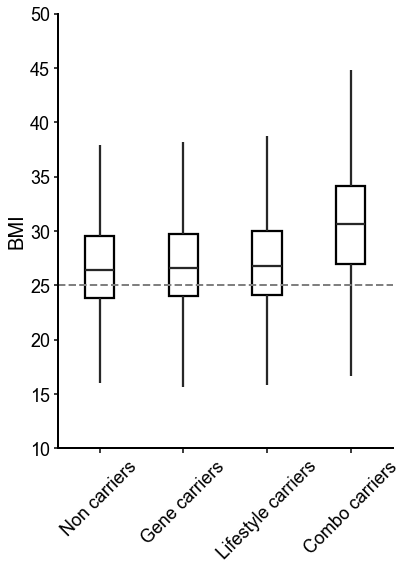

In [27]:
fig,ax = plt.subplots(figsize=(6, 8))

sns_box = sns.boxplot(
    data=plot_df, y="bmi", 
    x="category", order =[ "Non carriers","Gene carriers", "Lifestyle carriers", "Combo carriers",],
    hue="category", hue_order=[ "Non carriers","Gene carriers", "Lifestyle carriers", "Combo carriers",],
    palette=["#008176", "#00ADEE", "#ff7f0e", "#FF3688", ],  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7" "#eecc16"
    dodge=False, width=0.35, linewidth=2.25, fliersize=0, capprops={'color':'none'}, boxprops={'facecolor':'none', 'edgecolor':'k'}) # 


# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
ax.set_ylim((10, 50))
# ax.set_ylabel('Percentage')
ax.set_xticklabels(["Non carriers","Gene carriers", "Lifestyle carriers", "Combo carriers"], rotation=45, fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("BMI", fontsize=20)

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

# ax.axes.legend_.remove()
# sns_ax = sns.violinplot(
#     data=plot_df, y="bmi", 
#     x="category", order =[ "no gene or lifestyle", "genes only", "lifestyles only", "combos",],
#     hue="category", hue_order=[ "no gene or lifestyle", "genes only", "lifestyles only", "combos",],
#     palette=["#008176", "#08509b", "#ff7f0e", "#a30f15", ],
#     scale="area",
#     linewidth=2.5,
#     width=0.5,
#     dodge=False,
#     bw=0.75,
#     cut=2,
#     ax=ax
#     )
# # sns.stripplot(data=plot_df, y="bmi", x="category", color="k", ax=ax, s=2, alpha=0.1)
ax.axhline(y=25, linewidth=2, color='grey', linestyle='--')
# ax.set_xlabel("")
# ax.set_ylabel("BMI")
# # legend below as multiple columns
# h,l = sns_ax.axes.get_legend_handles_labels()
# sns_ax.axes.legend_.remove()
# sns_ax.legend(h,l, loc="upper center", ncol=4, bbox_to_anchor=(0.5, -0.1))


In [28]:
save_pdf("/data6/deepro/ukb_bmi/3_characterization/data/combos_in_cohort/lifestyle/figures/lifestyle_oligo.pdf", fig)